# Lezen van de files

Importeren libraries

In [12]:
import h5py
import os
import numpy as np
import random


Hier 1 class van maken, doet:
* lezen van de data
* Specificeren van de folder waarvan je de data wil inlezen in folder

## Class voor all preprocess stappen

### DATA PREPROCC (niet nodig als je de arrays gebruikt)

In [ ]:
import numpy as np
import os
import h5py
import random

class DataLoader:
    def __init__(self, base_directory=''):
        self.base_directory = base_directory

    def get_dataset_name(self, file_name_with_dir):
        filename_without_dir = file_name_with_dir.split('/')[-1]
        temp = filename_without_dir.split('_')[:-1]
        dataset_name = "_".join(temp)
        return dataset_name

    def znorm(self, data):
        """
        Normalizes time-wise
        """
        mean_rows = np.mean(data, axis=1, keepdims=True)
        std_rows = np.std(data, axis=1, keepdims=True)
        scaled_data = ((data - mean_rows) / std_rows)
        return scaled_data

    def load_data_from_folder(self, folder, shuffle=True, downsample_factor=2): # downsample factor kan worden aangepast
        # systematic sampling of average pooling
        data_directory = os.path.join(self.base_directory, folder)
        data = []
        labels = []

        label_mapping = {
            'rest': 0,
            'task_motor': 1,
            'task_story_math': 2,
            'task_working_memory': 3
        }

        file_names = [file_name for file_name in os.listdir(data_directory) if file_name.endswith(".h5")]
        if shuffle:
            random.shuffle(file_names)

        for file_name in file_names:
            file_path = os.path.join(data_directory, file_name)
            with h5py.File(file_path, 'r') as f:
                dataset_name = self.get_dataset_name(file_name)
                matrix = f.get(dataset_name)[()]

                label = None
                for task_prefix in label_mapping.keys():
                    if task_prefix in file_name:
                        label = label_mapping[task_prefix]  # Use the numerical value from label_mapping
                        break

                if label is not None:
                    matrix = self.znorm(matrix)
                    matrix = matrix[:, ::downsample_factor] # aanpassen boven >> systematic sampling

                    data.append(matrix)
                    labels.append(label)  # Append the label directly
                else:
                    print(f"Warning: No label found for file {file_name}")

        return np.array(data), np.array(labels)

# Example usage
data_loader = DataLoader()


#### cross

In [ ]:
# CROSS

# Load data and labels for each subset
data_train1, labels_train1 = data_loader.load_data_from_folder('Final_Project_data/Cross/train')
data_test1, labels_test1 = data_loader.load_data_from_folder('Final_Project_data/Cross/test1')
data_test2, labels_test2 = data_loader.load_data_from_folder('Final_Project_data/Cross/test2')
data_test3, labels_test3 = data_loader.load_data_from_folder('Final_Project_data/Cross/test3')

# Print shapes of loaded data
print(f"Train Data Shape: {data_train1.shape}, Train Labels Shape: {labels_train1.shape}")
print(f"Test1 Data Shape: {data_test1.shape}, Test1 Labels Shape: {labels_test1.shape}")
print(f"Test2 Data Shape: {data_test2.shape}, Test2 Labels Shape: {labels_test2.shape}")
print(f"Test3 Data Shape: {data_test3.shape}, Test3 Labels Shape: {labels_test3.shape}")

#### intra

In [ ]:
# intra train

# Load the preprocessed data and labels
data_train, labels_train = data_loader.load_data_from_folder('Final_Project_data/Intra/train')

# Print shapes of loaded data
print(f"Data Shape train: {data_train.shape}")
print(f"Labels Shape train: {labels_train.shape}")

## Test intra
# Load the preprocessed data and labels
data_test, labels_test = data_loader.load_data_from_folder('Final_Project_data/Intra/test')

# Print shapes of loaded data
print(f"Data Shape test: {data_test.shape}")
print(f"Labels Shape test: {labels_test.shape}")

#### rest

In [ ]:
from tensorflow.keras.utils import to_categorical
# reshapen zodat het in de vorm: [nr samples, time steps, features] is, voor LSTM
X_train = data_train
X_test = data_test
y_train = labels_train
y_test = labels_test
# Assuming y_train and y_test are currently integer labels
y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[2], X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2], X_test.shape[1]))

### Inlezen INTRA


In [13]:
# Inladen voor INTRA
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
X_test = np.load('/content/drive/MyDrive/arrays/X_test.npy')
X_train = np.load('/content/drive/MyDrive/arrays/X_train.npy')

y_test = np.load('/content/drive/MyDrive/arrays/y_test.npy')
y_train  = np.load('/content/drive/MyDrive/arrays/y_train.npy')

In [15]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

In [16]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Trainen + Maken van het model (intra)

In [ ]:
# Evaluate the model on a test set (assuming X_test and y_test)
loss, accuracy = stacked_lstm_model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

1/1 [==============================] - 1s 702ms/step - loss: 1.6126 - accuracy: 0.2500
Test Loss: 1.6126, Test Accuracy: 0.2500


### LSTM met hyperparametertuning

In [6]:
!pip3 install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 975.7 kB/s eta 0:00:00


In [ ]:
y_train_encoded.shape

(32, 4)

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

def build_model_storedParams(loaded_hyperparameters): # dit is de versie die met json params verder gaat
    model = Sequential()

    # Adding LSTM layers as per loaded hyperparameters
    for i in range(loaded_hyperparameters['num_lstm_layers']):
        model.add(LSTM(
            units=loaded_hyperparameters[f'units_{i}'],
            return_sequences=i < loaded_hyperparameters['num_lstm_layers'] - 1,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            dropout=loaded_hyperparameters.get('lstm_dropout_', 0)))

    # Adding Dense layers as per loaded hyperparameters
    for i in range(loaded_hyperparameters['num_dense_layers']):
        model.add(Dense(
            units=loaded_hyperparameters[f'dense_units_{i}'],
            activation='relu'))

    model.add(Dense(4, activation='softmax'))  # 4 classes

    model.compile(
        optimizer=tf.keras.optimizers.Adam(loaded_hyperparameters['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_model(hp):
    model = Sequential()

    # Tuning the number of LSTM layers and their units
    for i in range(hp.Int('num_lstm_layers', 1, 4)):
        model.add(LSTM(
            units=hp.Choice('units_' + str(i), values=[16, 32, 64, 128]), #values=[16, 32, 64, 128]
            return_sequences=i < hp.get('num_lstm_layers') - 1,  # Only the last layer should not return sequences
            input_shape=(X_train.shape[1], X_train.shape[2]),
            dropout=hp.Choice('lstm_dropout_', values=[0.1, 0.2, 0.3, 0.4, 0.5])))

    # Tuning the number of Dense layers and their units
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        model.add(Dense(
            units=hp.Choice('dense_units_' + str(i), values=[16, 32, 64, 128]), #values=[16, 32, 64, 128]
            activation='relu'))

    model.add(Dense(4, activation='softmax'))  # 4 classes

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), #values=[1e-2, 1e-3, 1e-4]
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='./',
    project_name='hparam_tuning'
)

tuner.search_space_summary()

# Start the hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=10, batch_size=8, validation_data=(X_test, y_test_encoded))
# epochs + batch size voor nu constant (behalve epochs bij fitten van model)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Reloading Tuner from ./hparam_tuning/tuner0.json
Search space summary
Default search space size: 12
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
lstm_dropout_ (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
dense_units_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
dense_units_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
dense_units_2 (Choice)
{'default

In [25]:
# voor normale getuned params
print(f"""
The hyperparameter search is complete.
The optimal number of LSTM and Dense layers and their units can be reviewed in the best hyperparameters.
""")

## Early stopping om te kijken of het effect heeft om het aantal epochs te verhogen
# Early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Increase the number of epochs as needed
epochs = 50
# Build the model with the optimal hyperparameters and train it

model = tuner.hypermodel.build(best_hps) ### HIER SWITCHEN NAAR BESTE HYPER PARAMETERS OF INLADEN VIA JSON loaded_hyperparameters

#model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test)) # epochs aanpassen voor snelheid
# deze was redelijk:
#model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded)) # kleinere batch size kan miss helpen? sotnd eerst op 64

model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=8, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping_callback])

# beste model als callback opslaan met .h5 of best params opslaan als file


The hyperparameter search is complete.
The optimal number of LSTM and Dense layers and their units can be reviewed in the best hyperparameters.

Epoch 1/50
4/4 [==============================] - 23s 4s/step - loss: 1.4231 - accuracy: 0.1562 - val_loss: 1.3724 - val_accuracy: 0.2500
Epoch 2/50
4/4 [==============================] - 10s 3s/step - loss: 1.4345 - accuracy: 0.1250 - val_loss: 1.3828 - val_accuracy: 0.2500
Epoch 3/50
4/4 [==============================] - 10s 3s/step - loss: 1.4053 - accuracy: 0.2188 - val_loss: 1.3713 - val_accuracy: 0.2500
Epoch 4/50
4/4 [==============================] - 7s 2s/step - loss: 1.3940 - accuracy: 0.2188 - val_loss: 1.3809 - val_accuracy: 0.2500
Epoch 5/50
4/4 [==============================] - 9s 2s/step - loss: 1.3944 - accuracy: 0.2188 - val_loss: 1.3867 - val_accuracy: 0.2500
Epoch 6/50
4/4 [==============================] - 7s 2s/step - loss: 1.3865 - accuracy: 0.1875 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 7/50
4/4 [=============

### Save / Store hyper params

In [18]:
## To see the best hyper params + valuesL:
print("Best Hyperparameters:")
for hyperparam in best_hps.values:
    print(f"{hyperparam}: {best_hps.get(hyperparam)}")


Best Hyperparameters:
num_lstm_layers: 4
units_0: 32
lstm_dropout_: 0.4
num_dense_layers: 1
dense_units_0: 16
learning_rate: 0.01
units_1: 32
dense_units_1: 128
dense_units_2: 128
dense_units_3: 128
units_2: 32
units_3: 16


In [20]:
# ALLEEN OPSLAAN ALS NODUIG
# save hyper params in file (als hoge accuracy)
import json

# Write the dictionary to a JSON file
with open('best_hyperparameters.json', 'w') as file:
    json.dump(best_hps, file)

In [21]:
# Load best hyper params:
# Read the hyperparameters from the JSON file
with open('best_hyperparameters.json', 'r') as file:
    loaded_hyperparameters = json.load(file)

# Now `loaded_hyperparameters` contains the hyperparameters


In [34]:
loaded_hyperparameters
"""
{'num_lstm_layers': 2,
 'units_0': 16,
 'lstm_dropout_': 0.3,
 'num_dense_layers': 3,
 'dense_units_0': 32,
 'learning_rate': 0.001,
 'units_1': 64,
 'units_2': 16,
 'dense_units_1': 16,
 'units_3': 32,
 'dense_units_2': 128,
 'dense_units_3': 16}
 """

{'num_lstm_layers': 2,
 'units_0': 16,
 'lstm_dropout_': 0.3,
 'num_dense_layers': 3,
 'dense_units_0': 32,
 'learning_rate': 0.001,
 'units_1': 64,
 'units_2': 16,
 'dense_units_1': 16,
 'units_3': 32,
 'dense_units_2': 128,
 'dense_units_3': 16}

In [31]:
# model draaien op json hyper params (opgeslagen)
model = build_model_storedParams(loaded_hyperparameters)

epochs = 50  # or any other number of epochs you want
batch_size = 8  # or any other batch size you want

# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train, y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stopping_callback]
)


Epoch 1/50
4/4 [==============================] - 11s 1s/step - loss: 1.3973 - accuracy: 0.1562 - val_loss: 1.3907 - val_accuracy: 0.3750
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 1.3904 - accuracy: 0.1250 - val_loss: 1.3756 - val_accuracy: 0.2500
Epoch 3/50
4/4 [==============================] - 5s 1s/step - loss: 1.3832 - accuracy: 0.2812 - val_loss: 1.3725 - val_accuracy: 0.3750
Epoch 4/50
4/4 [==============================] - 4s 1s/step - loss: 1.3826 - accuracy: 0.3125 - val_loss: 1.3709 - val_accuracy: 0.6250
Epoch 5/50
4/4 [==============================] - 4s 1s/step - loss: 1.3817 - accuracy: 0.2812 - val_loss: 1.3722 - val_accuracy: 0.2500
Epoch 6/50
4/4 [==============================] - 6s 2s/step - loss: 1.3763 - accuracy: 0.3438 - val_loss: 1.3674 - val_accuracy: 0.2500
Epoch 7/50
4/4 [==============================] - 4s 995ms/step - loss: 1.3760 - accuracy: 0.4375 - val_loss: 1.3663 - val_accuracy: 0.6250
Epoch 8/50
4/4 [=====================

1/1 [==============================] - 1s 1s/step


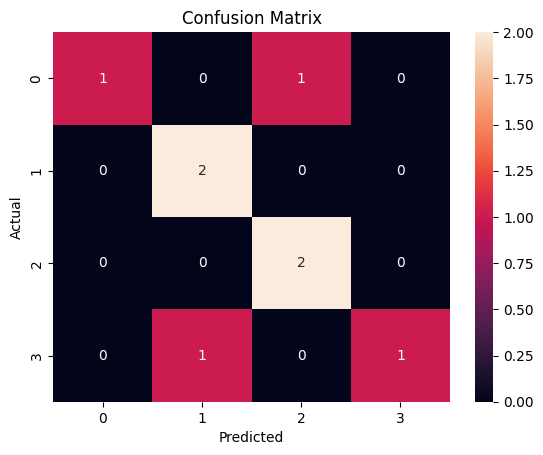

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2
           2       0.67      1.00      0.80         2
           3       1.00      0.50      0.67         2

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.83      0.75      0.73         8



In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report for additional metrics
print(classification_report(np.argmax(y_test_encoded, axis=1), y_pred_classes))


In [33]:
# Evaluating the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# Evaluating the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


1/1 [==============================] - 2s 2s/step - loss: 1.1673 - accuracy: 0.5000
Training Accuracy: 50.00%
1/1 [==============================] - 0s 483ms/step - loss: 1.2056 - accuracy: 0.7500
Test Accuracy: 75.00%


# opmerkingen INTRA

* train acc is 50%
* test acc 75%
* hyper params gevonden mbv hyper parameter tuning
* daarna deze waardes opgeslagen in json file
* model gefit mbv deze params
* epochs / batch sizes zouden nog getuned/getest kunnen worden

Zelfde wordt nu gedaan voor CROSS

Hierna statistische test doen op beide uitkomsten om te bepalen of er significantie is tussen de twee classificatie methoden.